In [10]:
# SETUP
import matplotlib.pyplot as plt
from sklearn.metrics import PrecisionRecallDisplay
import numpy as np
import json
import requests
import pandas as pd

# METRICS TABLE
# Define custom decorator to automatically calculate metric based on key
metrics = {}
metric = lambda f: metrics.setdefault(f.__name__, f)

@metric
def ap(results, relevant):
    """Average Precision"""
    precision_values = []
    precision_values = [
        len([
            doc 
            for doc in results[:idx]
            if doc in relevant
        ]) / idx 
        for idx, _ in enumerate(results, start=1)
    ]

    return sum(precision_values)/len(precision_values)

@metric
def p10(results, relevant, n=10):
    """Precision at N"""
    return len([doc for doc in results[:n] if doc in relevant])/n

# Define metrics to be calculated
evaluation_metrics = {
    'ap': 'Average Precision',
    'p10': 'Precision at 10 (P@10)'
}

class Evaluate:
    
    def __init__(self, results, relevant):
        self.results = results
        self.relevant = relevant
        # then remove
        print('Results: ', results)
        print('Relevant: ', relevant)
        
    def calculate_metric(self,metric):
        return metrics[metric](self.results, self.relevant)
    
    def export_metrics(self, file_path):
        df = pd.DataFrame([['Metric', 'Value']] + 
                          
            [[metric, self.calculate_metric(metric)] for metric in evaluation_metrics.keys()])

        with open(f'{file_path}/evaluation.tex', 'w+') as f:
            f.write(df.to_latex())
            
    def export_average_precision(self, file_path):
        average_precision = self.calculate_metric('ap')
        with open(f'{file_path}/average_precision.txt', 'w+') as f:
            f.write(str(average_precision))
            
    def precision_recall(self):
        
        if not self.results: return
        
        # Get precision and recall values
        precision_values = [
            len([
                doc 
                for doc in self.results[:idx]
                if doc in self.relevant
            ]) / idx 
            for idx, _ in enumerate(self.results, start=1)
        ]
        
        recall_values = [
            len([
                doc for doc in self.results[:idx]
                if doc in self.relevant
            ]) / len(self.relevant)
            for idx, _ in enumerate(self.results, start=1)
        ]
        
        precision_recall_match = {k: v for k,v in zip(recall_values, precision_values)}
        
        recall_values.extend([step for step in np.arange(0.1, 1.1, 0.1) if step not in recall_values])
        recall_values = sorted(set(recall_values))
        
        # Extend matching dict to include these new intermediate steps
        for idx, step in enumerate(recall_values):
            if step not in precision_recall_match:
                if recall_values[idx-1] in precision_recall_match:
                    precision_recall_match[step] = precision_recall_match[recall_values[idx-1]]
                else:
                    precision_recall_match[step] = precision_recall_match[recall_values[idx+1]]

        disp = PrecisionRecallDisplay([precision_recall_match.get(r) for r in recall_values], recall_values)
        disp.plot()
        plt.savefig('precision_recall.pdf')





Results:  ['1237', '1291', '1594', '1602', '1743', '1749', '1752', '1866', '2069']
Relevant:  ['1274', '1291', '1294', '1303', '1461', '1466', '1470', '1501', '1519', '1594', '1602', '1608', '1690', '1708', '1743', '1749', '1752', '1799', '1852', '1866', '1900', '1983', '2069', '2073']
Results:  ['1237', '1291', '1594', '1602', '1608', '1743', '1749', '1752', '1852', '1866', '2065', '2069']
Relevant:  ['1274', '1291', '1294', '1303', '1461', '1466', '1470', '1501', '1519', '1594', '1602', '1608', '1690', '1708', '1743', '1749', '1752', '1799', '1852', '1866', '1900', '1983', '2069', '2073']
Results:  ['1274', '1291', '1303', '1466', '1470', '1501', '1553', '1594', '1602', '1708']
Relevant:  ['1274', '1291', '1294', '1303', '1461', '1466', '1470', '1501', '1519', '1594', '1602', '1608', '1690', '1708', '1743', '1749', '1752', '1799', '1852', '1866', '1900', '1983', '2069', '2073']
Results:  ['1251', '1255', '1274', '1291', '1294', '1303', '1321', '1326', '1341', '1394', '1404', '1420', 

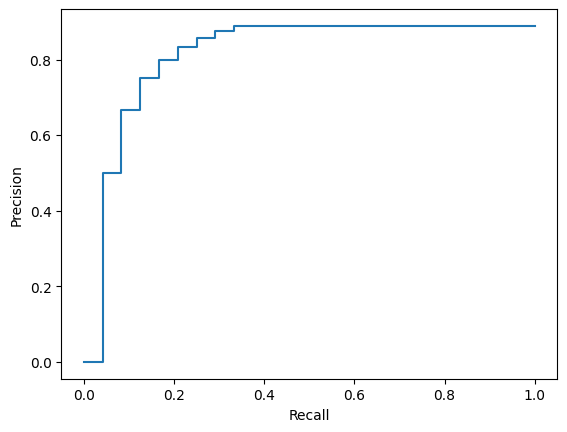

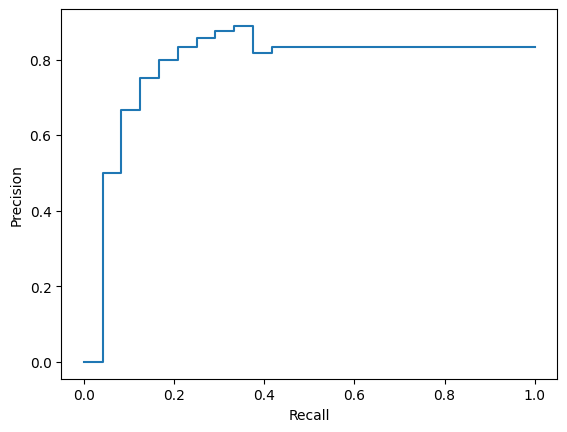

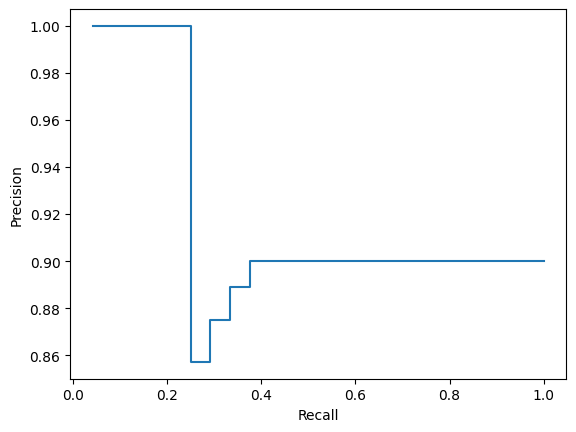

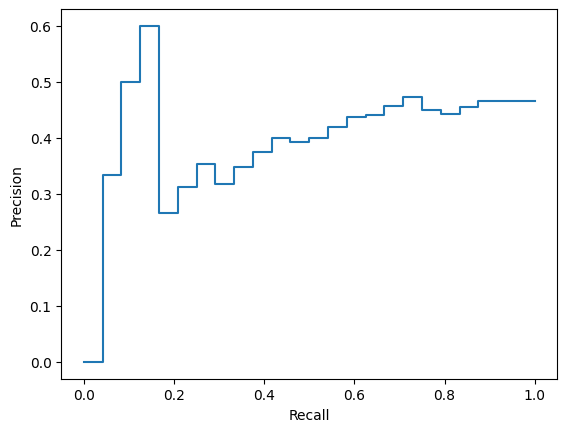

In [25]:
import os

QRELS_FILE = "./q1/qrels.txt"
queries = {
    "basic1": "http://localhost:8983/solr/simple_conversations/select?fl=*%2C%20%5Bchild%5D&indent=true&q.op=AND&q=%7B!parent%20which%3D%22genres%3Aaction%22%7D%20text%3A%20%22kill%22&rows=1000&useParams=",
    "basic2": "http://localhost:8983/solr/complex_conversations/select?fl=*%2C%20%5Bchild%5D&indent=true&q.op=AND&q=%7B!parent%20which%3D%22genres%3Aaction%22%7D%20text%3A%20%22kill%22&rows=1000&useParams=",
    "complex1":"http://localhost:8983/solr/simple_conversations/select?debug.explain.structured=true&debugQuery=true&fl=*%2C%20score%2C%20%5Bchild%5D&fq=genres%3Aaction&indent=true&q.op=AND&q=%7B!parent%20which%3Dcontent_type%3AparentDocument%7D%20(text%3A(kill*)%20%5E5)&useParams=",
    "complex2":"http://localhost:8983/solr/complex_conversations/select?debug.explain.structured=true&debugQuery=true&fl=*%2C%20score%2C%20%5Bchild%5D&fq=genres%3Aaction&indent=true&q.op=AND&q=%7B!parent%20which%3Dcontent_type%3AparentDocument%7D%20(text%3A(kill*)%20%5E5)&rows=100&useParams="
}

# Read qrels to extract relevant documents
relevant = list(map(lambda el: el.strip(), open(QRELS_FILE).readlines()))

results_dict = {}
resultGraphs = []

for query, url in queries.items():
    results = requests.get(url).json()['response']['docs']
    
    results = [x['id'] for x in results]
    results_dict[query] = results
    
    evaluation = Evaluate(results, relevant)
    path = f'./q1/{query}'
    
    if not os.path.exists(path):
        os.makedirs(path)
        
    evaluation.export_metrics(path)
    resultGraphs.append(evaluation.precision_recall())
    evaluation.export_average_precision(path)
    
for i in range(10):
    basic1_results = ('R' if results_dict['basic1'][i] in relevant else 'NR') if results_dict['basic1'] and i < len(results_dict['basic1']) else 'N/A'
    basic2_results = ('R' if results_dict['basic2'][i] in relevant else 'NR') if results_dict['basic2'] and i < len(results_dict['basic2']) else 'N/A'
    complex1_results = ('R' if results_dict['complex1'][i] in relevant else 'NR') if results_dict['complex1'] and i < len(results_dict['complex1']) else 'N/A'
    complex2_results = ('R' if results_dict['complex2'][i] in relevant else 'NR') if results_dict['complex2'] and i < len(results_dict['complex2']) else 'N/A'
    
    print(f'{i+1} & {basic1_results} & {basic2_results} & {complex1_results} & {complex2_results}\\\\')


In [ ]:
!pip install jinja2